# Usando modelos ARMA para pronosticar el número de manchas solares

En este proyecto pronosticaremos el número de manchas solares anuales usando el análisis de series de tiempo. 
El modelo que utilizaremos para hacer el pronóstico es el ARMA ($p,q$). Sin embargo, otros modelos pueden ser ajustados, como por ejemplo los basados en ondas sinusoidales o modelos ARIMA, entre otros.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/NASA%27s_SDO_Observes_Largest_Sunspot_of_the_Solar_Cycle_%2815430820129%29.jpg/800px-NASA%27s_SDO_Observes_Largest_Sunspot_of_the_Solar_Cycle_%2815430820129%29.jpg" width="400">

## ¿Qué son las manchas solares?

Las manchas solares son fenómenos temporales en la fotósfera del Sol que aparecen más oscuras que las áreas circundantes. 

## Datos

El conjunto de datos corresponde al número de manchas solares entre los años 1770 y 1869 (100 observaciones) y se puede encontrar en el libro Brockwell, Peter & Davis, Richard. (2002). An Introduction to Time Series and Forecasting (ejemplo 3.2.9).

In [86]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#Lectura de los datos
df=pd.read_csv('Sunspots.txt', names=['value'],header=0)
print(f"Total samples: {len(df)}")
df.head()

Total samples: 100


,value
0,101
1,82
2,66
3,35
4,31


Después de haber leído los datos, uno de los primeros pasos en el análisis de series de tiempo es graficar los datos en el dominio del tiempo y de la frecuencia.

**Análisis en el dominio del tiempo**

Graficamos las observaciones, su autocorrección y su autocorrelación parcial. Hacemos esto para comprender si existe alguna tendencia o estacionalidad.

C:\Users\darli\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


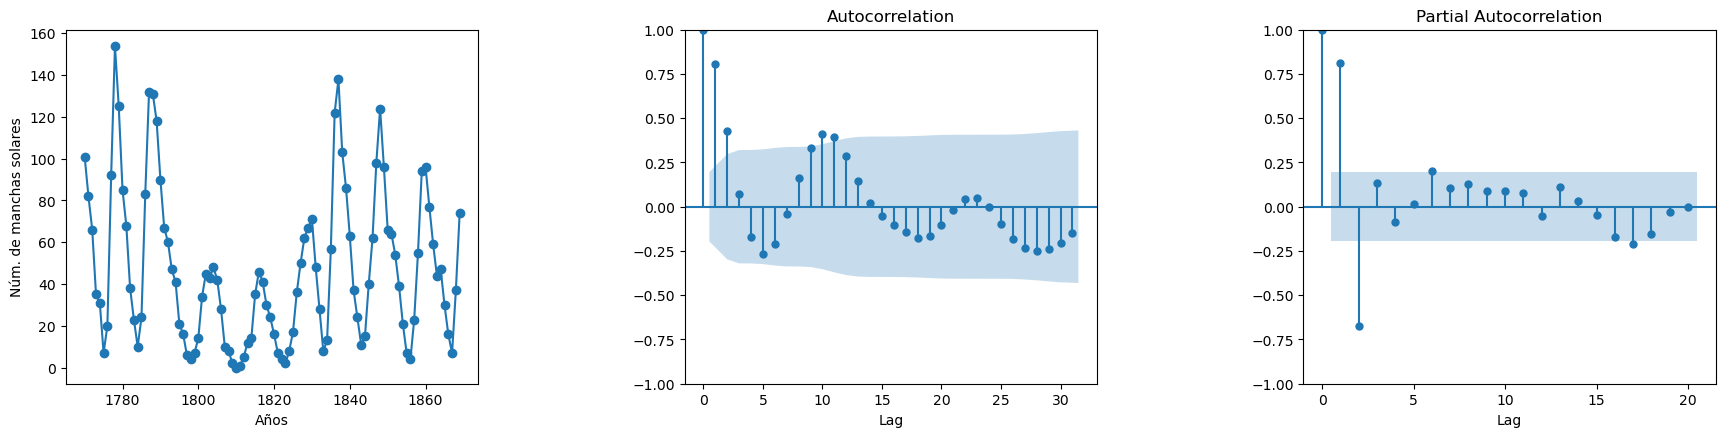

In [87]:
time=np.linspace(1770,1869,100)
plt.rcParams.update({'figure.figsize' : (10,3), 'figure.dpi' : 100})  
fig, axes = plt.subplots(1, 3, sharex = False)  
axes[0].plot(time,df.value,marker='o')
axes[0].set_xlabel('Años')
axes[0].set_ylabel('Núm. de manchas solares')
plot_acf(df.value, lags=31, ax = axes[1])  
axes[1].set_xlabel('Lag')
plot_pacf(df.value, ax = axes[2])  
axes[2].set_xlabel('Lag')
plt.subplots_adjust(top=1.2, bottom=0.02, left=0.05, right=1.7, hspace=0.4,
                    wspace=0.5)
plt.show() 

En el primer gráfico se puede ver una componente de estacionalidad. Sin embargo, cada pico (amplitud) varía en tamaño, lo cual limitará los modelos matemáticos basados en funciones sinusoidales $Y_t=A\sin(2\pi f t)$.\
Con respecto al segundo gráfico de autocorrelación, se observa un patrón estacional (sinusoidal) decayendo a medida que aumenta el lag. Este tipo de autocorrelación es propia de los datos que vienen del modelo $Y_t=A\sin(2\pi f t) + \epsilon_t$.\
En el último gráfico de autocorrelación parcial, observamos que la autocorrelación en los lags 0, 1, y 2 es significativa (fuera del intervalo de confianza). Esto se podría deber a que los datos provienen de un modelo ARMA(2,0).

**Análisis en el dominio de la frecuencia**

Graficamos el periodograma de las observamos para determinar si existe estacionalidad o autocorrelación.

Text(0, 0.5, 'Periodograma')

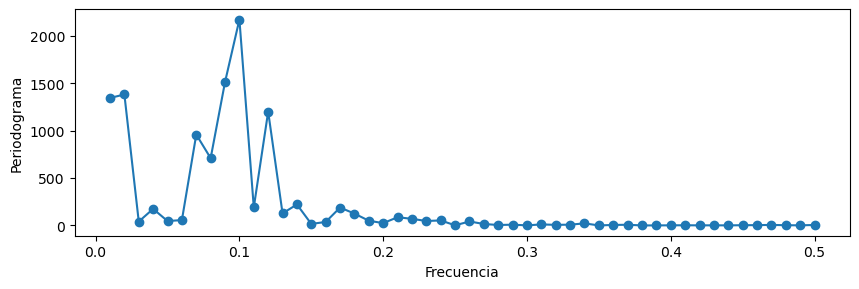

In [88]:
times = np.linspace(1,100,100)
freqs = np.linspace(1/len(times), 1.0 / (2.0 * (times[1] - times[0])), len(times) // 2)
fts = []
y=np.array(df.value)-np.mean(df.value)
for freq in freqs:
    A = np.sum(y * np.cos(2 * np.pi * times * freq))
    B = np.sum(y * np.sin(2 * np.pi * times * freq))
    fts.append(A**2 + B**2)
aux = 1 / (2 * np.pi*len(y))
fts = np.array(fts)*aux
plt.plot(freqs, fts,marker='o')
plt.xlabel('Frecuencia')
plt.ylabel('Periodograma')

Del gráfico anterior observamos que el periodograma tiene un solo pico aproximadamente en la frecuencia 0.1, lo que podría ser descrito por un modelo ARMA(2,0).

## Ajuste del modelo

Dado los graficos anteriores, ajustamos un modelo ARMA(2,0). Para evaluar el ajuste del modelo, dividimos el conjunto de datos en datos de entrenamiento y de testeo. Con los datos de entrenamiento (las primeras 66 observaciones) ajustamos el modelo ARMA(2,0), y con los datos de testeo (las siguientes 34 observaciones) evaluamos el pronósticos obtenido.

In [89]:
#Observaciones de entrenamiento y testeo
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [90]:
# Ajuste del modelo usando validación walk-forward (cross-validation)
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=83.318986, expected=122.000000
predicted=148.043348, expected=138.000000
predicted=122.877969, expected=103.000000
predicted=59.849001, expected=86.000000
predicted=62.967517, expected=63.000000
predicted=42.440855, expected=37.000000
predicted=21.632019, expected=24.000000
predicted=21.361651, expected=11.000000
predicted=11.865609, expected=15.000000
predicted=26.510669, expected=40.000000
predicted=59.101105, expected=62.000000
predicted=72.704983, expected=98.000000
predicted=108.794715, expected=124.000000
predicted=121.054723, expected=96.000000
predicted=61.422618, expected=66.000000
predicted=39.218953, expected=64.000000
predicted=58.072977, expected=54.000000
predicted=45.420357, expected=39.000000
predicted=31.234746, expected=21.000000
predicted=16.198048, expected=7.000000
predicted=8.836163, expected=4.000000
predicted=14.227985, expected=23.000000
predicted=43.257682, expected=55.000000
predicted=75.322691, expected=94.000000
predicted=108.442645, expected=96.0

In [130]:
# Ajuste
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -410.646
Date:                Mon, 03 Oct 2022   AIC                            829.293
Time:                        10:48:41   BIC                            839.673
Sample:                             0   HQIC                           833.493
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7975      6.201      7.708      0.000      35.644      59.951
ar.L1          1.4014      0.058     24.063      0.000       1.287       1.516
ar.L2         -0.7042      0.064    -10.948      0.0

## Validación de supuestos

Una vez ajustado el modelo, debemos evaluar si los residuos: 
1. Tienen media 0 y varianza constante a través del tiempo
2. No presentan autocorrelación, ni autocorrelación parcial
3. Distribuyen normal.

**Validación media igual a 0 y varianza constante**

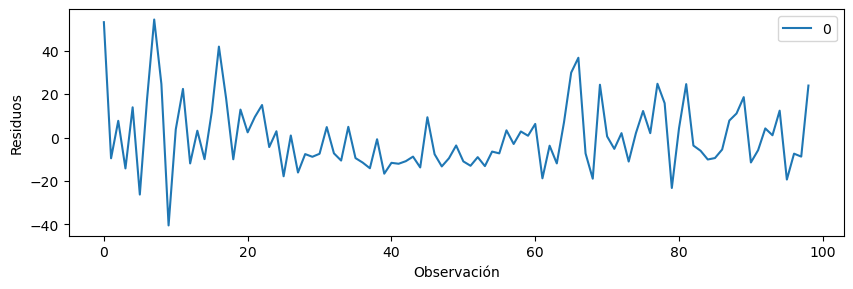

In [118]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.ylabel('Residuos')
plt.xlabel('Observación')
plt.show()

Del gráfico anterior observamos que los residuos no presentan tendencia, tienen media 0 y varianza constante, la cual valida el primer supuesto.

**Validación supuesto normalidad**

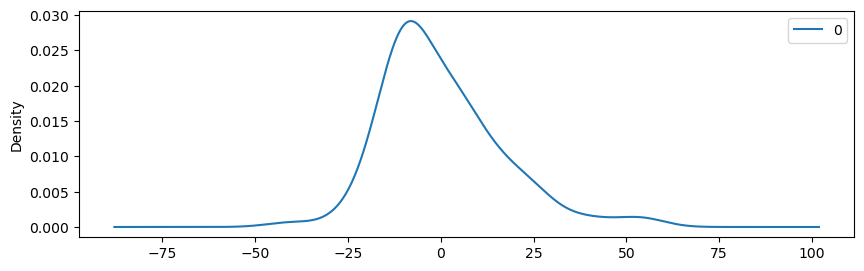

In [111]:
residuals.plot(kind='kde')
plt.show()

Del gráfico anterior observamos que la distribución de los residuos pareciera ser asimétrica, lo cual invalidaría el supuesto de normalidad (segundo supuesto).

**Validación autocorrelación**

C:\Users\darli\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


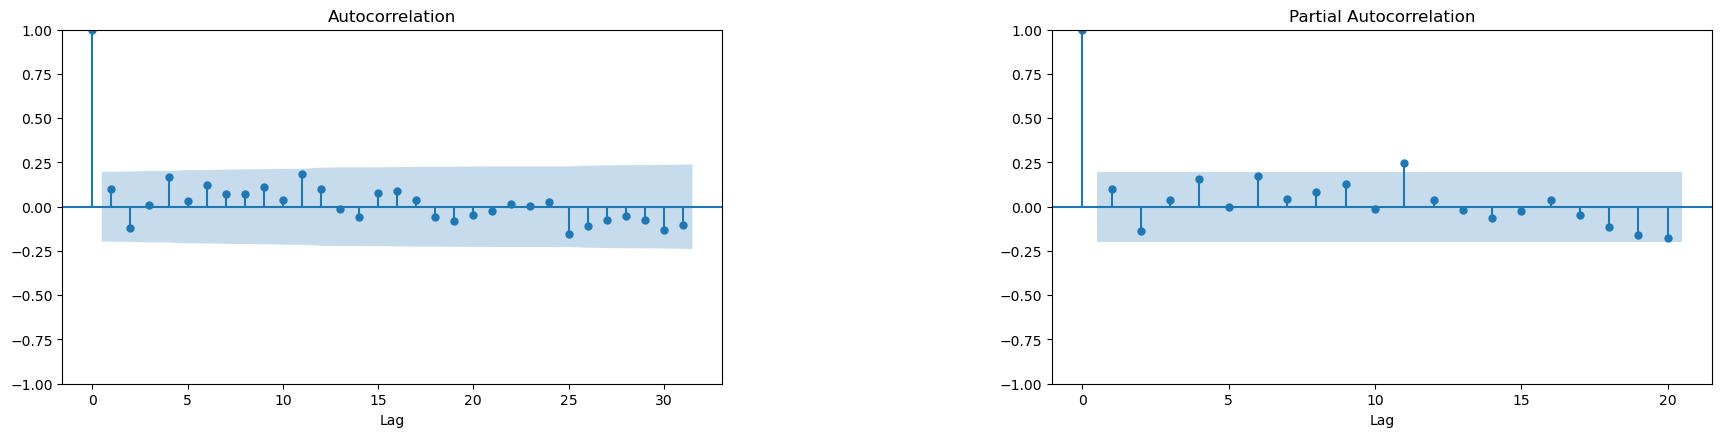

In [107]:
time=np.linspace(1770,1869,100)
plt.rcParams.update({'figure.figsize' : (10,3), 'figure.dpi' : 100})  
fig, axes = plt.subplots(1, 2, sharex = False)  
plot_acf(model_fit.resid, lags=31, ax = axes[0])  
axes[0].set_xlabel('Lag')
plot_pacf(model_fit.resid, ax = axes[1])  
axes[1].set_xlabel('Lag')
plt.subplots_adjust(top=1.2, bottom=0.02, left=0.05, right=1.7, hspace=0.4,
                    wspace=0.5)
plt.show() 

Del gráfico anterior observamos que los residuos no presentan autocorrelación ni autocorrelación parcial (la mayoría de las barras están contenidas dentro del intervalo de confianza), lo cual valida el tercer supuesto.

## Evaluación pronóstico (dominio del tiempo)

In [99]:
#Evaluación del pronóstico usando RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.968


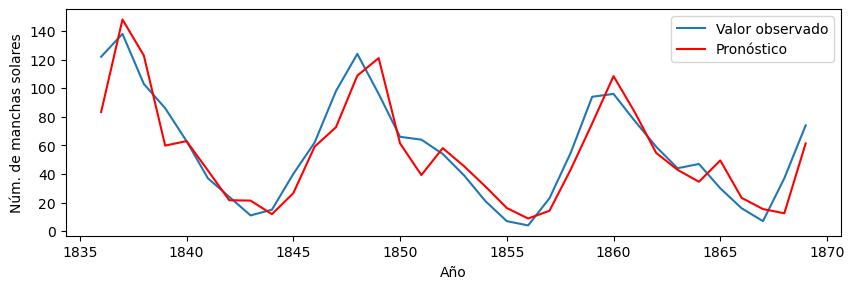

In [97]:
# plot forecasts against actual outcomes
time_test=np.linspace(1770+66,1869,34)
plt.plot(time_test,test,label='Valor observado')
plt.plot(time_test,predictions,label='Pronóstico',color='red')
plt.xlabel('Año')
plt.ylabel('Núm. de manchas solares')
plt.legend()
plt.show()

## Evaluación en el dominio de la frecuencia

In [123]:
#función para calcular la densidad espectral de un proceso ARMA
def PSD_ARMA(freq,sigma,phi_coefs,theta_coefs=[1.0]):  
    phi_coefs=np.insert(-phi_coefs,0,1) 
    ma_poly = np.polyval(theta_coefs[::-1], np.exp(2.0 * np.pi * 1j * freq) )  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(phi_coefs[::-1], np.exp(2.0 * np.pi * 1j * freq) )  # Evaluate the polynomial in the PSD denominator
    PSD = sigma ** 2 * np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2 / (2*np.pi)
    return(PSD)

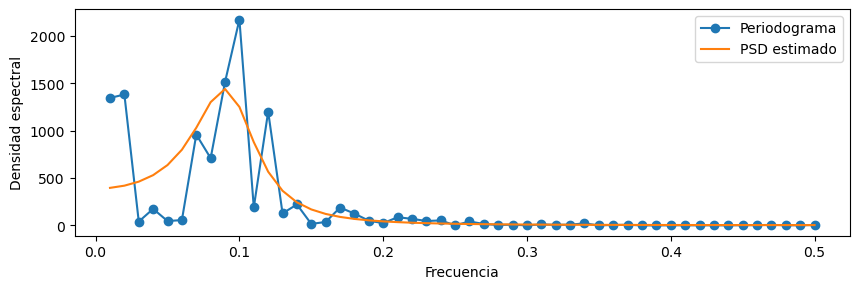

In [126]:
times = np.linspace(1,100,100)
freqs = np.linspace(1/len(times), 1.0 / (2.0 * (times[1] - times[0])), len(times) // 2)
PSD_hat=PSD_ARMA(freqs,sigma=sqrt(227.9237),phi_coefs=np.array([1.4076,-0.7128]))
fts = []
y=df.value-np.mean(df.value)
for freq in freqs:
    A = np.sum(y * np.cos(2 * np.pi * times * freq))
    B = np.sum(y * np.sin(2 * np.pi * times * freq))
    fts.append(A**2 + B**2)
aux = 1 / (2 * np.pi*len(y))
fts = np.array(fts)*aux
plt.plot(freqs, fts, label='Periodograma',marker='o')
plt.plot(freqs, PSD_hat, label='PSD estimado')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad espectral')
plt.legend()
plt.show()